In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from astropy.constants import G
import astropy.units as u
import seaborn as sns
from tqdm import tqdm

In [2]:
def search_closest_upper(value, array):
    diff = array - value
    return np.where(diff >= 0)[0][0]

In [3]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()

In [4]:
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
apx_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
#apx_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [4]:
time_list = np.array([ray_tree['0'][key]['time'] for key in ray_tree['0'].keys()])
idx_list = np.array([int(key) for key in ray_tree['0'].keys()])

In [5]:
ray_halo_wstars = {}
apx_halo_wstars = {}

In [7]:
idx = '170'

ray_halo_wstars_pos = np.empty(shape=(0,3))
ray_halo_wstars_rvir = np.array([])
ray_halo_wstars_branch = np.array([])
#ray_halo_wstars_dmmass = np.empty(shape=(0,1))

for key, vals in ray_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        ray_halo_wstars[key] = vals[idx]
        ray_halo_wstars_pos = np.vstack((ray_halo_wstars_pos, vals[idx]['coor']))
        ray_halo_wstars_rvir = np.append(ray_halo_wstars_rvir, vals[idx]['Rvir'])
        ray_halo_wstars_branch = np.append(ray_halo_wstars_branch, key)
        
for key, vals in apx_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        apx_halo_wstars[key] = vals[idx]

In [8]:
#Locate the overlapping halos. 
#For these halos, the stellar mass from the Thinh_structure file can be double counted. Therefore, we need to uniquely assign stars to each halo rather than loading the whole yt region.
overlap_pair = []
for i in range(len(ray_halo_wstars_branch)):
    for j in range(len(ray_halo_wstars_branch)):
        if (i == j) or sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]) in overlap_pair:
            continue
        else:
            if np.linalg.norm(ray_halo_wstars_pos[i] - ray_halo_wstars_pos[j]) < (ray_halo_wstars_rvir[i] + ray_halo_wstars_rvir[j]): #overlapping condition
                overlap_pair.append(sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]))

overlap_group = []
for pair in overlap_pair:
    if pair == overlap_pair[0]:
        group = pair
    else:
        if (pair[0] in group) or (pair[1] in group):
            group = list(set(group + pair))
        else:
            overlap_group.append(group)
            group = pair

In [9]:
#These are the groups of halos that need to be disentangled in terms of stellar mass
overlap_group

[['0_20', '0_21', '0', '0_16', '0_18', '0_19', '0_4', '0_2'],
 ['1', '1_14', '1_10'],
 ['3_1', '3', '3_7'],
 ['5', '5_1']]

In [76]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [79]:
group_test = np.array(overlap_group[0])
group_velcom = np.array([ray_rawtree[group_i][int(idx)]['Vel_Com'] for group_i in group_test])
#convert the unit of halo velocity from code_length/s to km/s
ds = yt.load(ray_pfs[int(idx)])
group_velcom = (group_velcom*ds.units.code_length/ds.units.s).to('km/s').v
group_starID = {}
allstars = []
for halo in group_test:
    halo_center = ray_tree[halo][idx]['coor']
    halo_radius = ray_tree[halo][idx]['Rvir']
    boolean = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_radius
    group_starID[halo] = ray_ID_all[boolean].astype(int)
    allstars = list(set(allstars + list(ray_ID_all[boolean].astype(int))))
allstars = np.array(group_allstars)

yt : [INFO     ] 2024-12-10 10:23:52,751 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2024-12-10 10:23:52,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-10 10:23:52,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-10 10:23:52,762 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-10 10:23:52,765 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-10 10:23:52,768 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2024-12-10 10:23:52,770 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-10 10:23:52,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: hubble_constant           = 0.679


In [32]:
group_starID

{'0_20': array([65363538, 65364102, 65364638, 65364670, 65364748]),
 '0_21': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
        65734358, 65734359, 65734360, 65734362, 65734363, 65734364,
        65734366]),
 '0': array([65363541, 65363542, 65364086, ..., 65665931, 65665937, 65724384]),
 '0_16': array([65363537, 65363546, 65363851, ..., 65665931, 65665937, 65724384]),
 '0_18': array([65363541, 65363542, 65364086, 65364088, 65364194, 65364698,
        65364664, 65364679, 65364681, 65614185, 65614414, 65617205,
        65659343, 65363652, 65363539, 65363540, 65363665, 65363673,
        65363674, 65363767, 65363773]),
 '0_19': array([65363541, 65363542, 65364086, 65364113, 65364693, 65364695,
        65364700, 65363652, 65363826, 65363539, 65363540, 65363665,
        65363673, 65363683, 65363767, 65363773, 65363831, 65364106]),
 '0_4': array([65364088, 65364194, 65364127, 65364129]),
 '0_2': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
       

In [33]:
allstars

array([65732608, 65658881, 65658882, ..., 65363965, 65724414, 65732607])

In [46]:
count_list = {}
for ID in allstars:
    count = 0
    branch_overlap = []
    for branch in group_starID.keys():
        if ID in group_starID[branch]:
            count += 1
            branch_overlap.append(branch)
    if count > 1:
        count_list[ID] = [count, branch_overlap]

In [85]:
ray_vel_all[ray_ID_all == 65732608]

array([[-65.81759841,  12.10400267, 120.21314368]])

In [90]:
ray_rawtree['0'][171]

{'NumParts': 10324,
 'Halo_Mass': 7628372984.201647,
 'Halo_Radius': 0.003219896406693052,
 'cden': 202.11934833096655,
 'r100': 0.0038463181360783145,
 'r150': 0.0036909953190874156,
 'r200': 0.003237456954225626,
 'r250': 0.0028894798550874417,
 'r300': 0.0026477752928777674,
 'r500': 0.0020518783497319,
 'r700': 0.001687430599046631,
 'Halo_Center': array([0.49444511, 0.50351903, 0.51216658]),
 'Vel_Com': array([-7.90055792e-19, -4.80827245e-20,  1.03378648e-19])}

In [86]:
count_list[65732608]

[2, ['0', '0_16']]

In [88]:
group_velcom[group_test == '0']

array([[-35.6028203 ,  -4.23333669,  10.90924301]])

In [89]:
group_velcom[group_test == '0_16']

array([[  8.91740217, -44.69326534,  60.8857723 ]])

In [65]:
group_test

['0_20', '0_21', '0_4', '0_16', '0', '0_18', '0_19', '0_2']

In [14]:
ray_pos_all.shape

(30056, 3)

In [17]:
ray_halo_wstars_pos

array([[0.49420246, 0.50316925, 0.51266823],
       [0.49296721, 0.50155015, 0.51324955],
       [0.47673882, 0.50389487, 0.5022506 ],
       [0.48908694, 0.50969391, 0.50063493],
       [0.50191681, 0.51200992, 0.53478709],
       [0.50191068, 0.51098171, 0.53401179],
       [0.50015472, 0.49932791, 0.512181  ],
       [0.48527808, 0.4967556 , 0.51121502],
       [0.50025661, 0.50790924, 0.53018027],
       [0.49264434, 0.51777617, 0.49249299],
       [0.48658425, 0.52111066, 0.52580045],
       [0.5022803 , 0.51522828, 0.53829083],
       [0.50312778, 0.51599952, 0.53952004]])

In [21]:
ray_halo_wstars.keys()

dict_keys(['0', '0_2', '1', '3', '4', '4_0', '5', '6', '8', '9', '18', '20', '69'])

In [22]:
ray_halo_wstars['0_2']

{'tree_loc': '0_2',
 'coor': array([0.49296721, 0.50155015, 0.51324955]),
 'Rvir': 0.0014047493591527603,
 'redshift': 10.886019680253,
 'time': 0.42308436376385633,
 'gas_mass': 170519124.77518892,
 'gas_mass_frac': 0.12780071866170767,
 'h2_mass': 5220394.575481022,
 'h2_fraction': 0.030614715987802243,
 'dm_mass': 1162249229.1687708,
 'pop2_mass': 1489589.9787338013,
 'pop3_mass': 5.17818883535532,
 'star_mass': 1489595.1569226366,
 'metal_mass': 14570.536272090665,
 'metallicity': 8.544810613648377e-05,
 'sfr': 0.0,
 'total_mass': 1334257949.1008823}

We need to assign each star to a unique halo. This can be done by tracking back the star's position when it first forms to see if it forms inside the same halo

In [8]:
ray_halo_idx = '0'
ray_halo_center = ray_tree[ray_halo_idx][idx]['coor']
ray_halo_rvir = ray_tree[ray_halo_idx][idx]['Rvir']

In [9]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())

In [10]:
halo_star_pos = ray_pos_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_age = ray_age_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_ID = ray_ID_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]

In [15]:
ftime_dict = {}
for j in range(len(halo_star_age)):
    ftime = time_list[-1] - halo_star_age[j]
    ftime_snapidx = idx_list[search_closest_upper(ftime, time_list)]
    try:
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))
    except:
        ftime_dict[ftime_snapidx] = []
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))

In [18]:
ftime_dict.keys()

dict_keys([80, 95, 117, 122, 124, 125, 154, 158, 159, 176, 190, 193, 194, 195, 201, 203, 130, 79, 156, 163, 198, 199, 114, 118, 200, 99, 109, 111, 112, 116, 119, 120, 121, 123, 127, 129, 131, 133, 134, 137, 138, 139, 141, 142, 143, 144, 160, 161, 175, 184, 202, 126, 150, 152, 162, 164, 169, 170, 174, 177, 178, 179, 183, 187, 191, 192, 204, 165, 180, 205, 206, 207, 208, 182, 209, 210, 211])

### Star Assignment Technique by Thinh

Starting from the earlier snapshot to the later snapshot. If a star particle is formed in a halo, assume that it will not escape that halo (there is a chance that during fly by, a DM halo can still some star particles, but since we are investigating star formation in halo, this can be neglected). If that halo is a sub branch, the star particle will belong to the main branch at the time step of merging. If a star particle is formed between the region of multiple halos, use energy definition to determine which halo it belongs to (choose the halo in which the star particle has the lowest total energy)

In [5]:
output = {}
for idx in range(21, 212):
    output[str(idx)] = {}

In [6]:
def list_of_halos_wstars_idx(tree, idx):
    halo_wstars_pos = np.empty(shape=(0,3))
    halo_wstars_rvir = np.array([])
    halo_wstars_branch = np.array([])
    for key, vals in tree.items():
        if idx in vals.keys() and vals[idx]['star_mass'] > 1:
            halo_wstars_pos = np.vstack((halo_wstars_pos, vals[idx]['coor']))
            halo_wstars_rvir = np.append(halo_wstars_rvir, vals[idx]['Rvir'])
            halo_wstars_branch = np.append(halo_wstars_branch, key)   
    return halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch

In [7]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

"""
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E
"""

"\ndef find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):\n    #this function calculate the total orbital energy of a star around a halo\n    #the unit of position is km and the unit of velocity is km/s\n    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity\n    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)\n    star_r = (star_r_codelength*ds.units.code_length).to('m').v\n    #\n    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v\n    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)\n    #Kinetic energy\n    KE = 0.5*star_relvel_mag**2\n    #Approximate M(r < star_r) by using the overdensity\n    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)\n    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v\n    oden_boolean = char_radius_list > star_r[:,np.newaxis]\n    oden = np.array([])\n    for j in range(len(o

In [8]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [9]:
print_mode = False

for idx in tqdm(range(21, 212)):
    idx = str(idx)
    #
    ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    ray_pos_all = ray_metadata['pos']
    ray_age_all = ray_metadata['age']
    ray_mass_all = ray_metadata['mass']
    ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    #
    if idx == '21':
        ray_ID_all_prev = np.array([])
    #
    ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
    ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    #Obtain the halos with stars
    halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
    #
    #The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
    halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
    #The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
    overlap_boolean = np.sum(halo_boolean, axis=1) 
    #
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
    ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
    halo_boolean_indp = halo_boolean[overlap_boolean == 1]
    #
    #The list of stars in each halo's region
    starmap_ID = []
    for j in range(halo_boolean_indp.shape[1]):
        starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    #
    if len(ray_ID_overlap) > 0:
        ds = yt.load(ray_pfs[int(idx)])
        ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
        ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
        overlap_branch_total = []
        for k in range(len(ray_ID_overlap)):
            overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
            E_list = np.array([])
            for branch in overlap_branch:
                overlap_branch_total.append(branch)
                E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
                E_list = np.append(E_list, E)
            bound_branch = overlap_branch[np.argmin(E_list)]
            #print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
            starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
        print('OVERLAP DETECTED AT BRANCHES', set(overlap_branch_total))
    len_starmap = [len(i) for i in starmap_ID]
    #
    for i in range(len(halo_wstars_branch)):
        if len(starmap_ID[i]) > 0: 
            for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
                if int(j) >= int(idx):
                    if halo_wstars_branch[i] not in output[j].keys():
                        output[j][halo_wstars_branch[i]] = starmap_ID[i]
                    else:
                        output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
            #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
            nlevels = halo_wstars_branch[i].count('_')
            if nlevels > 1:
                print('DEEPER SUB-BRANCHES DETECTED')
            loop_branch = halo_wstars_branch[i]
            for level in range(nlevels): #add the stars in the sub-branch to higher branches
                deepest_lvl = loop_branch.split('_')[-1]
                mainbranch = loop_branch.split('_' + deepest_lvl)[0]
                merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
                last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
                for j in range(merge_timestep, last_timestep + 1):
                    if mainbranch not in output[str(j)].keys():
                        output[str(j)][mainbranch] = starmap_ID[i]
                    else:
                        output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
                loop_branch = mainbranch
    #
    ray_ID_all_prev = ray_ID_all
    #
    if print_mode == True:
        print(idx, 'Number of total unassigned stars is:', len(ray_ID_unassign))
        print('Number of overlapped stars is', len(ray_ID_overlap), ', Number of independent stars is', len(ray_ID_indp))
        print('Halo with stars:', halo_wstars_branch)
        print('Number of assingned stars in each halo:', len_starmap, '\n')
        #print(starmap_ID,'\n')

 37%|███▋      | 70/191 [00:12<00:14,  8.36it/s]yt : [INFO     ] 2025-01-02 20:24:28,617 Parameters: current_time              = 14.485372364245
yt : [INFO     ] 2025-01-02 20:24:28,620 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:28,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:28,624 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:28,626 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:28,627 Parameters: current_redshift          = 13.847170857863
yt : [INFO     ] 2025-01-02 20:24:28,628 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:28,630 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:28,631 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:28,632 Parameters: hubble_constant           = 0.679
 37%|███▋      | 71/191 [00:15<01:36,  1.24it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_22'}


 39%|███▊      | 74/191 [00:15<00:51,  2.29it/s]yt : [INFO     ] 2025-01-02 20:24:29,335 Parameters: current_time              = 14.676545164245
yt : [INFO     ] 2025-01-02 20:24:29,338 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:29,340 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:29,342 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:29,343 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:29,345 Parameters: current_redshift          = 13.71792907663
yt : [INFO     ] 2025-01-02 20:24:29,346 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:29,348 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:29,349 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:29,350 Parameters: hubble_constant           = 0.679
 40%|███▉      | 76/191 [00:16<00:42,  2.69it/s]

OVERLAP DETECTED AT BRANCHES {'0_35', '0_34', '0'}


yt : [INFO     ] 2025-01-02 20:24:33,156 Parameters: current_time              = 14.772131564245
yt : [INFO     ] 2025-01-02 20:24:33,159 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:33,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:33,162 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:33,164 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:33,165 Parameters: current_redshift          = 13.65435486334
yt : [INFO     ] 2025-01-02 20:24:33,166 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:33,168 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:33,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:33,170 Parameters: hubble_constant           = 0.679
 40%|████      | 77/191 [00:19<02:18,  1.22s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_6'}


yt : [INFO     ] 2025-01-02 20:24:33,542 Parameters: current_time              = 14.819924764245
yt : [INFO     ] 2025-01-02 20:24:33,545 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:33,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:33,548 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:33,549 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:33,550 Parameters: current_redshift          = 13.622824169978
yt : [INFO     ] 2025-01-02 20:24:33,552 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:33,553 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:33,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:33,556 Parameters: hubble_constant           = 0.679
 41%|████      | 78/191 [00:20<01:51,  1.01it/s]

OVERLAP DETECTED AT BRANCHES {'6', '6_6'}


yt : [INFO     ] 2025-01-02 20:24:35,865 Parameters: current_time              = 14.867717964245
yt : [INFO     ] 2025-01-02 20:24:35,867 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:35,868 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:35,870 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:35,871 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:35,872 Parameters: current_redshift          = 13.591462463737
yt : [INFO     ] 2025-01-02 20:24:35,874 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:35,875 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:35,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:35,877 Parameters: hubble_constant           = 0.679
 41%|████▏     | 79/191 [00:22<02:34,  1.38s/it]

OVERLAP DETECTED AT BRANCHES {'6', '0_35', '0', '6_6', '0_34'}


yt : [INFO     ] 2025-01-02 20:24:40,935 Parameters: current_time              = 14.915511164245
yt : [INFO     ] 2025-01-02 20:24:40,937 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:40,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:40,940 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:40,942 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:40,943 Parameters: current_redshift          = 13.560268299869
yt : [INFO     ] 2025-01-02 20:24:40,944 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:40,946 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:40,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:40,948 Parameters: hubble_constant           = 0.679
 42%|████▏     | 80/191 [00:27<04:30,  2.44s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-02 20:24:41,418 Parameters: current_time              = 14.963304364245
yt : [INFO     ] 2025-01-02 20:24:41,421 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:41,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:41,424 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:41,425 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:41,427 Parameters: current_redshift          = 13.529240250548
yt : [INFO     ] 2025-01-02 20:24:41,428 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:41,429 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:41,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:41,432 Parameters: hubble_constant           = 0.679
 42%|████▏     | 81/191 [00:28<03:25,  1.87s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-02 20:24:46,791 Parameters: current_time              = 15.011097564245
yt : [INFO     ] 2025-01-02 20:24:46,793 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:46,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:46,796 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:46,797 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:46,798 Parameters: current_redshift          = 13.498376904632
yt : [INFO     ] 2025-01-02 20:24:46,800 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:46,801 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:46,802 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:46,804 Parameters: hubble_constant           = 0.679
 43%|████▎     | 82/191 [00:33<05:16,  2.91s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-02 20:24:47,202 Parameters: current_time              = 15.058890764245
yt : [INFO     ] 2025-01-02 20:24:47,204 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:47,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:47,207 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:47,208 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:47,209 Parameters: current_redshift          = 13.467676867405
yt : [INFO     ] 2025-01-02 20:24:47,211 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:47,212 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:47,213 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:47,214 Parameters: hubble_constant           = 0.679
 44%|████▍     | 84/191 [00:34<03:00,  1.68s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


 47%|████▋     | 90/191 [00:36<00:44,  2.29it/s]yt : [INFO     ] 2025-01-02 20:24:53,823 Parameters: current_time              = 15.441236364245
yt : [INFO     ] 2025-01-02 20:24:53,827 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:53,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:53,830 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:53,832 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:53,833 Parameters: current_redshift          = 13.227793550421
yt : [INFO     ] 2025-01-02 20:24:53,835 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:53,836 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:53,838 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:53,839 Parameters: hubble_constant           = 0.679
 48%|████▊     | 91/191 [00:40<02:44,  1.65s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 20:24:54,355 Parameters: current_time              = 15.489029564245
yt : [INFO     ] 2025-01-02 20:24:54,358 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:54,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:54,361 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:54,362 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:54,364 Parameters: current_redshift          = 13.19850312348
yt : [INFO     ] 2025-01-02 20:24:54,365 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:54,366 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:54,368 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:54,369 Parameters: hubble_constant           = 0.679
 49%|████▊     | 93/191 [00:41<01:33,  1.04it/s]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 20:24:54,965 Parameters: current_time              = 15.584615964245
yt : [INFO     ] 2025-01-02 20:24:54,967 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:54,969 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:54,970 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:54,971 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:54,973 Parameters: current_redshift          = 13.14037168221
yt : [INFO     ] 2025-01-02 20:24:54,974 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:54,975 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:54,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:54,978 Parameters: hubble_constant           = 0.679
 49%|████▉     | 94/191 [00:41<01:18,  1.24it/s]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 20:24:59,052 Parameters: current_time              = 15.632409164245
yt : [INFO     ] 2025-01-02 20:24:59,055 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:24:59,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:24:59,058 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:24:59,060 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:24:59,061 Parameters: current_redshift          = 13.111528223491
yt : [INFO     ] 2025-01-02 20:24:59,062 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:24:59,064 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:24:59,065 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:24:59,066 Parameters: hubble_constant           = 0.679
 50%|████▉     | 95/191 [00:45<02:51,  1.79s/it]

OVERLAP DETECTED AT BRANCHES {'1_18', '1'}


yt : [INFO     ] 2025-01-02 20:25:01,594 Parameters: current_time              = 15.680202364245
yt : [INFO     ] 2025-01-02 20:25:01,597 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:01,598 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:01,600 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:01,601 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:01,602 Parameters: current_redshift          = 13.082831332571
yt : [INFO     ] 2025-01-02 20:25:01,604 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:01,607 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:01,609 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:01,611 Parameters: hubble_constant           = 0.679
 50%|█████     | 96/191 [00:48<03:17,  2.08s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 20:25:02,258 Parameters: current_time              = 15.727995564245
yt : [INFO     ] 2025-01-02 20:25:02,261 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:02,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:02,264 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:02,266 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:02,267 Parameters: current_redshift          = 13.054279821133
yt : [INFO     ] 2025-01-02 20:25:02,269 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:02,270 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:02,271 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:02,273 Parameters: hubble_constant           = 0.679
 51%|█████     | 97/191 [00:49<02:42,  1.73s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 20:25:08,054 Parameters: current_time              = 15.775788764245
yt : [INFO     ] 2025-01-02 20:25:08,056 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:08,057 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:08,059 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:08,060 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:08,062 Parameters: current_redshift          = 13.025872514067
yt : [INFO     ] 2025-01-02 20:25:08,063 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:08,064 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:08,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:08,067 Parameters: hubble_constant           = 0.679
 51%|█████▏    | 98/191 [00:54<04:23,  2.83s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-02 20:25:08,492 Parameters: current_time              = 15.823581964245
yt : [INFO     ] 2025-01-02 20:25:08,495 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:08,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:08,499 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:08,501 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:08,502 Parameters: current_redshift          = 12.997608249284
yt : [INFO     ] 2025-01-02 20:25:08,504 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:08,505 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:08,507 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:08,508 Parameters: hubble_constant           = 0.679
 52%|█████▏    | 99/191 [00:55<03:15,  2.13s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '0_30', '0'}


yt : [INFO     ] 2025-01-02 20:25:09,207 Parameters: current_time              = 15.871375164245
yt : [INFO     ] 2025-01-02 20:25:09,210 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:09,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:09,214 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:09,216 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:09,218 Parameters: current_redshift          = 12.969485877534
yt : [INFO     ] 2025-01-02 20:25:09,219 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:09,221 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:09,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:09,224 Parameters: hubble_constant           = 0.679
 52%|█████▏    | 100/191 [00:56<02:33,  1.69s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '0_30', '0'}


yt : [INFO     ] 2025-01-02 20:25:10,287 Parameters: current_time              = 15.919168364245
yt : [INFO     ] 2025-01-02 20:25:10,290 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:10,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:10,293 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:10,294 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:10,295 Parameters: current_redshift          = 12.941504262223
yt : [INFO     ] 2025-01-02 20:25:10,297 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:10,298 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:10,299 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:10,300 Parameters: hubble_constant           = 0.679
 53%|█████▎    | 101/191 [00:57<02:14,  1.49s/it]

OVERLAP DETECTED AT BRANCHES {'1_18', '4_10', '4', '1'}


 53%|█████▎    | 102/191 [00:57<01:41,  1.13s/it]yt : [INFO     ] 2025-01-02 20:25:11,008 Parameters: current_time              = 16.014754764245
yt : [INFO     ] 2025-01-02 20:25:11,011 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:11,012 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:11,014 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:11,015 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:11,017 Parameters: current_redshift          = 12.885958816771
yt : [INFO     ] 2025-01-02 20:25:11,018 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:11,019 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:11,020 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:11,022 Parameters: hubble_constant           = 0.679
 54%|█████▍    | 103/191 [00:57<01:19,  1.11it/

OVERLAP DETECTED AT BRANCHES {'0_29', '0'}


yt : [INFO     ] 2025-01-02 20:25:13,965 Parameters: current_time              = 16.062547964245
yt : [INFO     ] 2025-01-02 20:25:13,967 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:13,969 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:13,970 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:13,972 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:13,973 Parameters: current_redshift          = 12.858392775155
yt : [INFO     ] 2025-01-02 20:25:13,974 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:13,976 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:13,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:13,978 Parameters: hubble_constant           = 0.679
 55%|█████▍    | 105/191 [01:01<01:44,  1.21s/it]

OVERLAP DETECTED AT BRANCHES {'0_28', '0'}


yt : [INFO     ] 2025-01-02 20:25:15,090 Parameters: current_time              = 16.158134364245
yt : [INFO     ] 2025-01-02 20:25:15,093 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:15,094 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:15,096 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:15,097 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:15,098 Parameters: current_redshift          = 12.803668615465
yt : [INFO     ] 2025-01-02 20:25:15,100 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:15,101 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:15,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:15,104 Parameters: hubble_constant           = 0.679
 55%|█████▌    | 106/191 [01:01<01:26,  1.02s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '1429_0'}


yt : [INFO     ] 2025-01-02 20:25:15,438 Parameters: current_time              = 16.205927564245
yt : [INFO     ] 2025-01-02 20:25:15,441 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:15,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:15,444 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:15,446 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:15,447 Parameters: current_redshift          = 12.776508357231
yt : [INFO     ] 2025-01-02 20:25:15,448 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:15,450 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:15,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:15,452 Parameters: hubble_constant           = 0.679
 56%|█████▌    | 107/191 [01:02<01:11,  1.17it/s]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '1429_0'}


yt : [INFO     ] 2025-01-02 20:25:16,071 Parameters: current_time              = 16.253720764245
yt : [INFO     ] 2025-01-02 20:25:16,074 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:16,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:16,077 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:16,078 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:16,079 Parameters: current_redshift          = 12.749481239204
yt : [INFO     ] 2025-01-02 20:25:16,081 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:16,082 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:16,083 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:16,084 Parameters: hubble_constant           = 0.679
 57%|█████▋    | 108/191 [01:02<01:06,  1.25it/s]

OVERLAP DETECTED AT BRANCHES {'4_10', '4', '1429_0', '4_8'}


yt : [INFO     ] 2025-01-02 20:25:19,216 Parameters: current_time              = 16.301513964245
yt : [INFO     ] 2025-01-02 20:25:19,219 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:19,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:19,222 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:19,223 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:19,225 Parameters: current_redshift          = 12.722586219928
yt : [INFO     ] 2025-01-02 20:25:19,226 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:19,227 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:19,228 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:19,230 Parameters: hubble_constant           = 0.679
 57%|█████▋    | 109/191 [01:06<02:01,  1.49s/it]

OVERLAP DETECTED AT BRANCHES {'1429_0', '4', '0', '4_10', '4_8', '0_26'}


yt : [INFO     ] 2025-01-02 20:25:21,141 Parameters: current_time              = 16.349307164245
yt : [INFO     ] 2025-01-02 20:25:21,144 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:21,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:21,147 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:21,148 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:21,149 Parameters: current_redshift          = 12.695822269115
yt : [INFO     ] 2025-01-02 20:25:21,151 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:21,152 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:21,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:21,155 Parameters: hubble_constant           = 0.679
 58%|█████▊    | 110/191 [01:07<02:08,  1.59s/it]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}


yt : [INFO     ] 2025-01-02 20:25:38,515 Parameters: current_time              = 16.397100364245
yt : [INFO     ] 2025-01-02 20:25:38,518 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:38,519 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:38,520 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:38,522 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:38,523 Parameters: current_redshift          = 12.669188367492
yt : [INFO     ] 2025-01-02 20:25:38,525 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:38,526 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:38,527 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:38,528 Parameters: hubble_constant           = 0.679
 58%|█████▊    | 111/191 [01:25<08:25,  6.32s/it]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}


yt : [INFO     ] 2025-01-02 20:25:38,857 Parameters: current_time              = 16.444893564245
yt : [INFO     ] 2025-01-02 20:25:38,860 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:38,862 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:38,864 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:38,866 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:38,867 Parameters: current_redshift          = 12.642683506655
yt : [INFO     ] 2025-01-02 20:25:38,869 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:38,870 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:38,872 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:38,873 Parameters: hubble_constant           = 0.679
 59%|█████▊    | 112/191 [01:25<05:58,  4.54s/it]

OVERLAP DETECTED AT BRANCHES {'4', '4_8'}


yt : [INFO     ] 2025-01-02 20:25:39,328 Parameters: current_time              = 16.492686764245
yt : [INFO     ] 2025-01-02 20:25:39,330 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:39,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:39,333 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:39,335 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:39,336 Parameters: current_redshift          = 12.616306688919
yt : [INFO     ] 2025-01-02 20:25:39,337 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:39,339 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:39,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:39,341 Parameters: hubble_constant           = 0.679
 60%|█████▉    | 114/191 [01:26<03:05,  2.40s/it]

OVERLAP DETECTED AT BRANCHES {'4', '4_8'}


 61%|██████    | 116/191 [01:27<01:41,  1.35s/it]yt : [INFO     ] 2025-01-02 20:25:40,823 Parameters: current_time              = 16.683859564245
yt : [INFO     ] 2025-01-02 20:25:40,826 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:40,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:40,829 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:40,831 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:40,832 Parameters: current_redshift          = 12.512060262453
yt : [INFO     ] 2025-01-02 20:25:40,834 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:40,835 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:40,836 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:40,838 Parameters: hubble_constant           = 0.679
 61%|██████▏   | 117/191 [01:27<01:22,  1.11s/i

OVERLAP DETECTED AT BRANCHES {'4', '4_8'}


 63%|██████▎   | 120/191 [01:28<00:35,  2.00it/s]yt : [INFO     ] 2025-01-02 20:25:41,921 Parameters: current_time              = 16.875032364245
yt : [INFO     ] 2025-01-02 20:25:41,923 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:41,925 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:41,926 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:41,928 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:41,929 Parameters: current_redshift          = 12.40978540168
yt : [INFO     ] 2025-01-02 20:25:41,930 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:41,932 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:41,933 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:41,934 Parameters: hubble_constant           = 0.679
 63%|██████▎   | 121/191 [01:28<00:33,  2.11it/s

OVERLAP DETECTED AT BRANCHES {'4_7', '4'}


yt : [INFO     ] 2025-01-02 20:25:42,473 Parameters: current_time              = 16.922825564245
yt : [INFO     ] 2025-01-02 20:25:42,476 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:42,477 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:42,479 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:42,480 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:42,481 Parameters: current_redshift          = 12.384517775072
yt : [INFO     ] 2025-01-02 20:25:42,483 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:42,484 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:42,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:42,487 Parameters: hubble_constant           = 0.679
 64%|██████▍   | 122/191 [01:29<00:35,  1.95it/s]

OVERLAP DETECTED AT BRANCHES {'4_7_0', '4_7', '4'}


yt : [INFO     ] 2025-01-02 20:25:46,450 Parameters: current_time              = 16.970618764245
yt : [INFO     ] 2025-01-02 20:25:46,452 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:46,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:46,455 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:46,456 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:46,458 Parameters: current_redshift          = 12.359368773632
yt : [INFO     ] 2025-01-02 20:25:46,459 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:46,460 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:46,462 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:46,463 Parameters: hubble_constant           = 0.679
 64%|██████▍   | 123/191 [01:33<01:47,  1.57s/it]

OVERLAP DETECTED AT BRANCHES {'4_7', '4'}


yt : [INFO     ] 2025-01-02 20:25:48,335 Parameters: current_time              = 17.018411964245
yt : [INFO     ] 2025-01-02 20:25:48,337 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:48,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:48,340 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:48,341 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:48,343 Parameters: current_redshift          = 12.33433750855
yt : [INFO     ] 2025-01-02 20:25:48,344 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:48,345 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:48,347 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:48,348 Parameters: hubble_constant           = 0.679
 65%|██████▍   | 124/191 [01:35<01:48,  1.62s/it]

OVERLAP DETECTED AT BRANCHES {'3', '3_8'}


yt : [INFO     ] 2025-01-02 20:25:48,668 Parameters: current_time              = 17.066205164245
yt : [INFO     ] 2025-01-02 20:25:48,672 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:48,673 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:48,675 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:48,676 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:48,678 Parameters: current_redshift          = 12.309423100143
yt : [INFO     ] 2025-01-02 20:25:48,679 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:48,680 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:48,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:48,683 Parameters: hubble_constant           = 0.679
 66%|██████▌   | 126/191 [01:35<01:01,  1.06it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_8'}


 67%|██████▋   | 128/191 [01:36<00:33,  1.86it/s]yt : [INFO     ] 2025-01-02 20:25:51,834 Parameters: current_time              = 17.257377964245
yt : [INFO     ] 2025-01-02 20:25:51,836 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:51,838 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:51,839 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:51,841 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:51,842 Parameters: current_redshift          = 12.210916752618
yt : [INFO     ] 2025-01-02 20:25:51,844 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:51,845 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:51,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:51,847 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 129/191 [01:38<01:10,  1.14s/i

OVERLAP DETECTED AT BRANCHES {'6', '6_4'}


yt : [INFO     ] 2025-01-02 20:25:52,184 Parameters: current_time              = 17.305171164245
yt : [INFO     ] 2025-01-02 20:25:52,186 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:52,188 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:52,189 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:52,191 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:52,192 Parameters: current_redshift          = 12.186573743727
yt : [INFO     ] 2025-01-02 20:25:52,193 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:52,195 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:52,196 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:52,197 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 130/191 [01:39<00:56,  1.07it/s]

OVERLAP DETECTED AT BRANCHES {'6', '6_4'}


 69%|██████▉   | 132/191 [01:39<00:33,  1.77it/s]yt : [INFO     ] 2025-01-02 20:25:53,209 Parameters: current_time              = 17.448550764245
yt : [INFO     ] 2025-01-02 20:25:53,211 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:53,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:53,213 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:53,215 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:53,216 Parameters: current_redshift          = 12.114212032114
yt : [INFO     ] 2025-01-02 20:25:53,217 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:53,219 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:53,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:53,221 Parameters: hubble_constant           = 0.679
 70%|██████▉   | 133/191 [01:40<00:32,  1.76it/

OVERLAP DETECTED AT BRANCHES {'44', '5'}


 70%|███████   | 134/191 [01:40<00:28,  2.03it/s]yt : [INFO     ] 2025-01-02 20:25:54,014 Parameters: current_time              = 17.544137164245
yt : [INFO     ] 2025-01-02 20:25:54,017 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:54,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:54,020 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:54,022 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:54,023 Parameters: current_redshift          = 12.06651889921
yt : [INFO     ] 2025-01-02 20:25:54,025 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:54,026 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:54,027 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:54,029 Parameters: hubble_constant           = 0.679
 71%|███████   | 135/191 [01:40<00:26,  2.08it/s

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-02 20:25:57,016 Parameters: current_time              = 17.591930364245
yt : [INFO     ] 2025-01-02 20:25:57,018 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:57,020 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:57,022 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:57,023 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:57,025 Parameters: current_redshift          = 12.042834351225
yt : [INFO     ] 2025-01-02 20:25:57,026 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:57,027 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:57,029 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:57,030 Parameters: hubble_constant           = 0.679
 71%|███████   | 136/191 [01:43<01:07,  1.24s/it]

OVERLAP DETECTED AT BRANCHES {'0_2_0', '1', '1_15', '0_2'}


yt : [INFO     ] 2025-01-02 20:25:57,412 Parameters: current_time              = 17.639723564245
yt : [INFO     ] 2025-01-02 20:25:57,415 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:57,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:57,417 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:57,419 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:57,420 Parameters: current_redshift          = 12.019256774436
yt : [INFO     ] 2025-01-02 20:25:57,422 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:57,423 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:57,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:57,425 Parameters: hubble_constant           = 0.679
 72%|███████▏  | 137/191 [01:44<00:55,  1.02s/it]

OVERLAP DETECTED AT BRANCHES {'44', '1_15', '5', '1'}


yt : [INFO     ] 2025-01-02 20:25:58,047 Parameters: current_time              = 17.687516764245
yt : [INFO     ] 2025-01-02 20:25:58,050 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:58,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:58,053 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:58,054 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:58,056 Parameters: current_redshift          = 11.995785397681
yt : [INFO     ] 2025-01-02 20:25:58,057 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:58,058 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:58,060 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:58,061 Parameters: hubble_constant           = 0.679
 72%|███████▏  | 138/191 [01:44<00:45,  1.17it/s]

OVERLAP DETECTED AT BRANCHES {'0_24', '0'}


yt : [INFO     ] 2025-01-02 20:25:58,483 Parameters: current_time              = 17.735309964245
yt : [INFO     ] 2025-01-02 20:25:58,485 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:58,486 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:58,488 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:58,489 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:58,491 Parameters: current_redshift          = 11.972419457422
yt : [INFO     ] 2025-01-02 20:25:58,492 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:58,493 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:58,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:58,496 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 139/191 [01:45<00:38,  1.37it/s]

OVERLAP DETECTED AT BRANCHES {'0_24', '0'}


yt : [INFO     ] 2025-01-02 20:25:58,941 Parameters: current_time              = 17.783103164245
yt : [INFO     ] 2025-01-02 20:25:58,944 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:58,945 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:58,947 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:58,948 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:58,949 Parameters: current_redshift          = 11.949158197647
yt : [INFO     ] 2025-01-02 20:25:58,951 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:58,952 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:58,953 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:58,955 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 140/191 [01:46<00:40,  1.27it/s]

OVERLAP DETECTED AT BRANCHES {'44', '0_24', '5', '0'}


yt : [INFO     ] 2025-01-02 20:25:59,856 Parameters: current_time              = 17.830896364245
yt : [INFO     ] 2025-01-02 20:25:59,859 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:25:59,860 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:25:59,862 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:25:59,863 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:25:59,865 Parameters: current_redshift          = 11.926000869779
yt : [INFO     ] 2025-01-02 20:25:59,866 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:25:59,867 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:25:59,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:25:59,870 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 141/191 [01:46<00:36,  1.38it/s]

OVERLAP DETECTED AT BRANCHES {'0_24', '0'}


yt : [INFO     ] 2025-01-02 20:26:00,652 Parameters: current_time              = 17.878689564245
yt : [INFO     ] 2025-01-02 20:26:00,655 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:00,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:00,659 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:00,660 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:00,661 Parameters: current_redshift          = 11.902946732583
yt : [INFO     ] 2025-01-02 20:26:00,663 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:00,664 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:00,665 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:00,666 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 142/191 [01:47<00:34,  1.40it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_8', '0_24', '0'}


yt : [INFO     ] 2025-01-02 20:26:01,259 Parameters: current_time              = 17.926482764245
yt : [INFO     ] 2025-01-02 20:26:01,262 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:01,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:01,265 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:01,267 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:01,268 Parameters: current_redshift          = 11.879995052069
yt : [INFO     ] 2025-01-02 20:26:01,270 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:01,271 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:01,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:01,274 Parameters: hubble_constant           = 0.679
 75%|███████▍  | 143/191 [01:48<00:33,  1.45it/s]

OVERLAP DETECTED AT BRANCHES {'0_24', '0_2', '0_4', '0', '0_21'}


yt : [INFO     ] 2025-01-02 20:26:01,743 Parameters: current_time              = 17.974275964245
yt : [INFO     ] 2025-01-02 20:26:01,745 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:01,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:01,748 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:01,750 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:01,751 Parameters: current_redshift          = 11.85714510141
yt : [INFO     ] 2025-01-02 20:26:01,752 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:01,753 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:01,755 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:01,756 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 144/191 [01:48<00:31,  1.47it/s]

OVERLAP DETECTED AT BRANCHES {'3_8', '0_24', '3_7', '0_18', '3', '0', '0_4'}


yt : [INFO     ] 2025-01-02 20:26:02,359 Parameters: current_time              = 18.022069164245
yt : [INFO     ] 2025-01-02 20:26:02,361 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:02,363 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:02,364 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:02,366 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:02,367 Parameters: current_redshift          = 11.834396160849
yt : [INFO     ] 2025-01-02 20:26:02,368 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:02,370 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:02,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:02,372 Parameters: hubble_constant           = 0.679
 76%|███████▌  | 145/191 [01:49<00:27,  1.68it/s]

OVERLAP DETECTED AT BRANCHES {'3_8', '0_24', '3_7', '3', '0', '0_4'}


yt : [INFO     ] 2025-01-02 20:26:06,422 Parameters: current_time              = 18.069862364245
yt : [INFO     ] 2025-01-02 20:26:06,424 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:06,425 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:06,427 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:06,428 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:06,430 Parameters: current_redshift          = 11.811747517612
yt : [INFO     ] 2025-01-02 20:26:06,431 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:06,432 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:06,433 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:06,435 Parameters: hubble_constant           = 0.679
 76%|███████▋  | 146/191 [01:53<01:17,  1.72s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '1_15', '3_7', '3', '1', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:07,248 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-02 20:26:07,249 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:07,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:07,252 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:07,254 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:07,255 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-02 20:26:07,256 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:07,257 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:07,259 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:07,260 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 147/191 [01:54<01:03,  1.45s/it]

OVERLAP DETECTED AT BRANCHES {'1_15', '3_7', '3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:18,710 Parameters: current_time              = 18.165448764245
yt : [INFO     ] 2025-01-02 20:26:18,712 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:18,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:18,715 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:18,717 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:18,718 Parameters: current_redshift          = 11.766748306412
yt : [INFO     ] 2025-01-02 20:26:18,719 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:18,720 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:18,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:18,723 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 148/191 [02:06<03:17,  4.59s/it]

OVERLAP DETECTED AT BRANCHES {'1_15', '3_7', '3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:19,838 Parameters: current_time              = 18.213241964245
yt : [INFO     ] 2025-01-02 20:26:19,840 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:19,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:19,843 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:19,844 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:19,846 Parameters: current_redshift          = 11.744396347051
yt : [INFO     ] 2025-01-02 20:26:19,847 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:19,848 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:19,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:19,851 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 149/191 [02:07<02:25,  3.47s/it]

OVERLAP DETECTED AT BRANCHES {'1', '0_16', '1_10', '0'}


yt : [INFO     ] 2025-01-02 20:26:20,774 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-02 20:26:20,776 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:20,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:20,779 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:20,781 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:20,782 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-02 20:26:20,783 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:20,785 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:20,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:20,787 Parameters: hubble_constant           = 0.679
 79%|███████▊  | 150/191 [02:08<01:52,  2.75s/it]

OVERLAP DETECTED AT BRANCHES {'3_7', '5', '3', '1', '3_1', '0', '5_1', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:21,794 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-02 20:26:21,797 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:21,799 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:21,800 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:21,802 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:21,803 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-02 20:26:21,804 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:21,805 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:21,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:21,808 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 151/191 [02:08<01:24,  2.10s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:22,354 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-02 20:26:22,357 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:22,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:22,360 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:22,362 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:22,363 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-02 20:26:22,365 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:22,366 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:22,367 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:22,368 Parameters: hubble_constant           = 0.679
 80%|███████▉  | 152/191 [02:09<01:05,  1.67s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:27,926 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-02 20:26:27,928 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:27,929 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:27,931 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:27,932 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:27,934 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-02 20:26:27,935 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:27,936 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:27,937 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:27,939 Parameters: hubble_constant           = 0.679
 80%|████████  | 153/191 [02:15<01:53,  2.99s/it]

OVERLAP DETECTED AT BRANCHES {'3_6', '3', '1', '3_1', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:29,244 Parameters: current_time              = 18.452207964245
yt : [INFO     ] 2025-01-02 20:26:29,245 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:29,247 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:29,248 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:29,250 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:29,251 Parameters: current_redshift          = 11.634085780014
yt : [INFO     ] 2025-01-02 20:26:29,252 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:29,253 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:29,255 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:29,256 Parameters: hubble_constant           = 0.679
 81%|████████  | 154/191 [02:16<01:31,  2.48s/it]

OVERLAP DETECTED AT BRANCHES {'6', '5', '0_18', '3_6', '3', '1', '3_1', '5_1', '0', '6_2', '0_19', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:30,615 Parameters: current_time              = 18.500001164245
yt : [INFO     ] 2025-01-02 20:26:30,617 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:30,618 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:30,620 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:30,621 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:30,623 Parameters: current_redshift          = 11.612308848527
yt : [INFO     ] 2025-01-02 20:26:30,624 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:30,625 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:30,626 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:30,628 Parameters: hubble_constant           = 0.679
 81%|████████  | 155/191 [02:17<01:13,  2.04s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '8_1', '8_2', '0_16', '0_19', '8', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:31,441 Parameters: current_time              = 18.547794364245
yt : [INFO     ] 2025-01-02 20:26:31,442 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:31,443 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:31,445 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:31,446 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:31,448 Parameters: current_redshift          = 11.590625452402
yt : [INFO     ] 2025-01-02 20:26:31,449 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:31,450 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:31,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:31,453 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 156/191 [02:19<01:03,  1.81s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '3_1', '0', '0_16', '0_19'}


yt : [INFO     ] 2025-01-02 20:26:32,720 Parameters: current_time              = 18.595587564245
yt : [INFO     ] 2025-01-02 20:26:32,721 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:32,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:32,724 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:32,726 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:32,727 Parameters: current_redshift          = 11.569034950277
yt : [INFO     ] 2025-01-02 20:26:32,728 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:32,730 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:32,731 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:32,732 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 157/191 [02:19<00:47,  1.41s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '3_1', '0', '0_16', '0_19'}


yt : [INFO     ] 2025-01-02 20:26:33,282 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-02 20:26:33,284 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:33,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:33,287 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:33,288 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:33,289 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-02 20:26:33,291 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:33,292 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:33,293 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:33,294 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 158/191 [02:20<00:39,  1.20s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '8_1', '8_2', '0_16', '0_19', '8', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:35,881 Parameters: current_time              = 18.691173964245
yt : [INFO     ] 2025-01-02 20:26:35,883 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:35,885 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:35,886 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:35,888 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:35,889 Parameters: current_redshift          = 11.526130092664
yt : [INFO     ] 2025-01-02 20:26:35,890 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:35,892 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:35,893 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:35,894 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 159/191 [02:22<00:51,  1.61s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '0_19', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:41,759 Parameters: current_time              = 18.738967164245
yt : [INFO     ] 2025-01-02 20:26:41,761 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:41,763 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:41,764 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:41,766 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:41,767 Parameters: current_redshift          = 11.50481448432
yt : [INFO     ] 2025-01-02 20:26:41,768 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:41,769 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:41,771 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:41,772 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 160/191 [02:28<01:29,  2.87s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '8_2', '0_16', '0_19', '8', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:42,270 Parameters: current_time              = 18.786760364245
yt : [INFO     ] 2025-01-02 20:26:42,272 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:42,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:42,275 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:42,276 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:42,278 Parameters: current_redshift          = 11.483589264125
yt : [INFO     ] 2025-01-02 20:26:42,279 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:42,280 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:42,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:42,283 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 161/191 [02:29<01:05,  2.18s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_8', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:54,334 Parameters: current_time              = 18.834553564245
yt : [INFO     ] 2025-01-02 20:26:54,337 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:54,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:54,341 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:54,343 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:54,345 Parameters: current_redshift          = 11.462453820163
yt : [INFO     ] 2025-01-02 20:26:54,347 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:54,349 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:54,351 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:54,353 Parameters: hubble_constant           = 0.679
 85%|████████▍ | 162/191 [02:41<02:31,  5.22s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '1_8', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:55,169 Parameters: current_time              = 18.882346764245
yt : [INFO     ] 2025-01-02 20:26:55,171 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:55,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:55,176 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:55,178 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:55,180 Parameters: current_redshift          = 11.441407546199
yt : [INFO     ] 2025-01-02 20:26:55,181 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:55,183 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:55,185 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:55,187 Parameters: hubble_constant           = 0.679
 85%|████████▌ | 163/191 [02:42<01:52,  4.01s/it]

OVERLAP DETECTED AT BRANCHES {'0_18', '3', '1', '3_1', '0', '1_8', '0_16', '0_17', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:56,330 Parameters: current_time              = 18.930139964245
yt : [INFO     ] 2025-01-02 20:26:56,332 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:56,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:56,337 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:56,339 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:56,341 Parameters: current_redshift          = 11.420449841614
yt : [INFO     ] 2025-01-02 20:26:56,343 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:56,345 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:56,346 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:56,348 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 164/191 [02:44<01:27,  3.25s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '0', '1_8', '8_2', '8', '0_16', '3_2', '0_17', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:57,869 Parameters: current_time              = 18.977933164245
yt : [INFO     ] 2025-01-02 20:26:57,871 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:57,873 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:57,875 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:57,877 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:57,879 Parameters: current_redshift          = 11.399580111337
yt : [INFO     ] 2025-01-02 20:26:57,881 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:57,883 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:57,885 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:57,887 Parameters: hubble_constant           = 0.679
 86%|████████▋ | 165/191 [02:45<01:10,  2.72s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_8', '8_2', '8', '1_10'}


yt : [INFO     ] 2025-01-02 20:26:59,463 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2025-01-02 20:26:59,465 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:26:59,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:26:59,469 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:26:59,472 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:26:59,473 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2025-01-02 20:26:59,475 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:26:59,477 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:26:59,479 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:26:59,481 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 166/191 [02:46<00:56,  2.24s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '1_8', '8_2', '8', '1_10'}


yt : [INFO     ] 2025-01-02 20:27:00,464 Parameters: current_time              = 19.073519564245
yt : [INFO     ] 2025-01-02 20:27:00,466 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:00,468 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:00,470 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:00,473 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:00,475 Parameters: current_redshift          = 11.358102220772
yt : [INFO     ] 2025-01-02 20:27:00,477 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:00,478 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:00,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:00,482 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 167/191 [02:47<00:42,  1.76s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '0', '1_8', '0_16', '1_10'}


yt : [INFO     ] 2025-01-02 20:27:01,137 Parameters: current_time              = 19.121312764245
yt : [INFO     ] 2025-01-02 20:27:01,139 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:01,141 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:01,143 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:01,145 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:01,147 Parameters: current_redshift          = 11.337492897503
yt : [INFO     ] 2025-01-02 20:27:01,149 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:01,150 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:01,152 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:01,154 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 169/191 [02:48<00:22,  1.02s/it]

OVERLAP DETECTED AT BRANCHES {'8_2', '8'}


 90%|████████▉ | 171/191 [02:49<00:15,  1.31it/s]yt : [INFO     ] 2025-01-02 20:27:02,894 Parameters: current_time              = 19.312485564245
yt : [INFO     ] 2025-01-02 20:27:02,896 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:02,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:02,899 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:02,901 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:02,903 Parameters: current_redshift          = 11.255906429548
yt : [INFO     ] 2025-01-02 20:27:02,904 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:02,905 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:02,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:02,908 Parameters: hubble_constant           = 0.679
 90%|█████████ | 172/191 [02:49<00:14,  1.32it/

OVERLAP DETECTED AT BRANCHES {'0_13', '3', '3_1', '0'}


yt : [INFO     ] 2025-01-02 20:27:03,708 Parameters: current_time              = 19.360278764245
yt : [INFO     ] 2025-01-02 20:27:03,711 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:03,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:03,715 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:03,717 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:03,718 Parameters: current_redshift          = 11.235719715924
yt : [INFO     ] 2025-01-02 20:27:03,720 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:03,722 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:03,724 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:03,726 Parameters: hubble_constant           = 0.679
 91%|█████████ | 173/191 [02:50<00:14,  1.28it/s]

OVERLAP DETECTED AT BRANCHES {'0_13', '3', '3_1', '0'}


yt : [INFO     ] 2025-01-02 20:27:04,817 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2025-01-02 20:27:04,819 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:04,821 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:04,822 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:04,824 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:04,825 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2025-01-02 20:27:04,827 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:04,828 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:04,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:04,831 Parameters: hubble_constant           = 0.679
 91%|█████████ | 174/191 [02:52<00:19,  1.14s/it]

OVERLAP DETECTED AT BRANCHES {'0_13', '3', '3_1', '0'}


yt : [INFO     ] 2025-01-02 20:27:06,338 Parameters: current_time              = 19.455865164245
yt : [INFO     ] 2025-01-02 20:27:06,339 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:06,341 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:06,343 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:06,344 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:06,346 Parameters: current_redshift          = 11.195594319384
yt : [INFO     ] 2025-01-02 20:27:06,347 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:06,348 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:06,350 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:06,351 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 175/191 [02:53<00:17,  1.08s/it]

OVERLAP DETECTED AT BRANCHES {'3', '0_13', '3_1', '0'}


yt : [INFO     ] 2025-01-02 20:27:07,362 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 20:27:07,364 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:07,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:07,367 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:07,369 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:07,370 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 20:27:07,372 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:07,373 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:07,374 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:07,376 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 176/191 [02:54<00:14,  1.06it/s]

OVERLAP DETECTED AT BRANCHES {'9_1_0', '1', '9', '9_1_1_0', '1_8', '9_1'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-02 20:27:08,150 Parameters: current_time              = 19.551451564245
yt : [INFO     ] 2025-01-02 20:27:08,152 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:08,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:08,156 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:08,158 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:08,160 Parameters: current_redshift          = 11.155796034681
yt : [INFO     ] 2025-01-02 20:27:08,162 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:08,164 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:08,166 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:08,168 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 177/191 [02:54<00:12,  1.15it/s]

OVERLAP DETECTED AT BRANCHES {'9', '9_1_0', '9_1'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-02 20:27:08,654 Parameters: current_time              = 19.599244764245
yt : [INFO     ] 2025-01-02 20:27:08,656 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:08,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:08,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:08,662 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:08,664 Parameters: current_redshift          = 11.136018228952
yt : [INFO     ] 2025-01-02 20:27:08,666 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:08,668 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:08,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:08,672 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 178/191 [02:55<00:12,  1.07it/s]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_1', '0', '0_13', '1_8'}


yt : [INFO     ] 2025-01-02 20:27:09,644 Parameters: current_time              = 19.647037964245
yt : [INFO     ] 2025-01-02 20:27:09,646 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:09,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:09,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:09,652 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:09,654 Parameters: current_redshift          = 11.116320614298
yt : [INFO     ] 2025-01-02 20:27:09,656 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:09,658 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:09,660 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:09,662 Parameters: hubble_constant           = 0.679
 94%|█████████▎| 179/191 [02:56<00:10,  1.13it/s]

OVERLAP DETECTED AT BRANCHES {'0_13', '0'}


yt : [INFO     ] 2025-01-02 20:27:10,403 Parameters: current_time              = 19.694831164245
yt : [INFO     ] 2025-01-02 20:27:10,405 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:10,407 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:10,409 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:10,411 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:10,413 Parameters: current_redshift          = 11.096702671559
yt : [INFO     ] 2025-01-02 20:27:10,415 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:10,417 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:10,419 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:10,421 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 180/191 [02:57<00:09,  1.22it/s]

OVERLAP DETECTED AT BRANCHES {'0_13', '0'}


yt : [INFO     ] 2025-01-02 20:27:13,413 Parameters: current_time              = 19.742624364245
yt : [INFO     ] 2025-01-02 20:27:13,415 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:13,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:13,419 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:13,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:13,423 Parameters: current_redshift          = 11.077163886182
yt : [INFO     ] 2025-01-02 20:27:13,425 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:13,427 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:13,429 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:13,431 Parameters: hubble_constant           = 0.679
 95%|█████████▍| 181/191 [03:00<00:16,  1.62s/it]

OVERLAP DETECTED AT BRANCHES {'3', '0_13', '3_1', '0'}


 95%|█████████▌| 182/191 [03:01<00:10,  1.19s/it]yt : [INFO     ] 2025-01-02 20:27:14,799 Parameters: current_time              = 19.838210764245
yt : [INFO     ] 2025-01-02 20:27:14,801 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:14,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:14,806 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:14,808 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:14,810 Parameters: current_redshift          = 11.038321752048
yt : [INFO     ] 2025-01-02 20:27:14,812 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:14,814 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:14,815 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:14,817 Parameters: hubble_constant           = 0.679
 96%|█████████▌| 183/191 [03:01<00:07,  1.03it/

OVERLAP DETECTED AT BRANCHES {'9', '9_1_0', '9_1', '9_1_1'}


 96%|█████████▋| 184/191 [03:01<00:05,  1.29it/s]yt : [INFO     ] 2025-01-02 20:27:15,571 Parameters: current_time              = 19.933797164245
yt : [INFO     ] 2025-01-02 20:27:15,574 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:15,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:15,578 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:15,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:15,582 Parameters: current_redshift          = 10.999790185728
yt : [INFO     ] 2025-01-02 20:27:15,584 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:15,586 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:15,588 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:15,590 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 185/191 [03:04<00:07,  1.23s/i

OVERLAP DETECTED AT BRANCHES {'9_1_0', '3', '9', '3_1', '9_1_1', '8_2', '8', '8_0', '9_1'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-02 20:27:17,970 Parameters: current_time              = 19.981590364245
yt : [INFO     ] 2025-01-02 20:27:17,973 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:17,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:17,977 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:17,979 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:17,981 Parameters: current_redshift          = 10.980639626643
yt : [INFO     ] 2025-01-02 20:27:17,983 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:17,985 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:17,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:17,988 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 186/191 [03:04<00:05,  1.09s/it]

OVERLAP DETECTED AT BRANCHES {'8_2', '8', '8_0'}


yt : [INFO     ] 2025-01-02 20:27:18,674 Parameters: current_time              = 20.029383564245
yt : [INFO     ] 2025-01-02 20:27:18,676 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:18,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:18,680 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:18,682 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:18,684 Parameters: current_redshift          = 10.961565231562
yt : [INFO     ] 2025-01-02 20:27:18,686 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:18,688 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:18,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:18,692 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 187/191 [03:05<00:03,  1.09it/s]

OVERLAP DETECTED AT BRANCHES {'8_2', '8', '8_0'}


yt : [INFO     ] 2025-01-02 20:27:19,145 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-02 20:27:19,147 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:19,149 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:19,151 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:19,153 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:19,155 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-02 20:27:19,157 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:19,159 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:19,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:19,163 Parameters: hubble_constant           = 0.679
 99%|█████████▉| 189/191 [03:06<00:01,  1.44it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_1', '8_2', '8', '8_0'}


yt : [INFO     ] 2025-01-02 20:27:20,147 Parameters: current_time              = 20.172763164245
yt : [INFO     ] 2025-01-02 20:27:20,150 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 20:27:20,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 20:27:20,154 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 20:27:20,156 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 20:27:20,158 Parameters: current_redshift          = 10.904794214388
yt : [INFO     ] 2025-01-02 20:27:20,160 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 20:27:20,162 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 20:27:20,164 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 20:27:20,166 Parameters: hubble_constant           = 0.679
 99%|█████████▉| 190/191 [03:06<00:00,  1.65it/s]

OVERLAP DETECTED AT BRANCHES {'18_5', '18', '18_4'}


100%|██████████| 191/191 [03:07<00:00,  1.02it/s]


In [50]:
output_check = {}
for idx in output.keys():
    output_check[idx] = {}
    stars_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    stars_pos_all = stars_metadata['pos']
    stars_mass_all = stars_metadata['mass']
    stars_age_all = stars_metadata['age']
    stars_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    for branch in output[idx].keys():
        stars_ID = output[idx][branch]
        stars_pos = stars_pos_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_mass = stars_mass_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_age = stars_age_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_ID = stars_ID_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        #
        halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
        halo_radius = ray_rawtree[branch][int(idx)]['Halo_Radius']
        #
        check_bool = np.linalg.norm(stars_pos - halo_center, axis=1) < halo_radius
        stars_ID_check = stars_ID[check_bool]
        stars_pos_check = stars_pos[check_bool]
        stars_mass_check = stars_mass[check_bool]
        stars_age_check = stars_age[check_bool]
        output_check[idx][branch] = {}
        output_check[idx][branch]['ID'] = stars_ID_check
        output_check[idx][branch]['total_mass'] = np.sum(stars_mass_check)
        output_check[idx][branch]['sfr'] = np.sum(stars_mass_check[stars_age_check < 0.01])/1e7 #sfr is averaged on the timescale of 10 million years

In [22]:
time = []
n_halowstars_total = []
n_halowstars_range1 = [] #range 1: Halo Mass < 1e9 
n_halowstars_range2 = [] #range 2: 1e9 < Halo Mass < 1e10
n_halowstars_range3 = [] #range 3: Halo Mass > 1e10
for idx in output_check.keys():
    time.append(ray_tree['0'][idx]['time'])
    n_total = 0 #counter for n_halowstars_total
    n1 = 0 #counter for n_halowstars_range1
    n2 = 0 #counter for n_halowstars_range2
    n3 = 0 #counter for n_halowstars_range3
    for branch in output_check[idx].keys():
        halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
        if output_check[idx][branch]['total_mass'] > 0:
            n_total += 1
        if output_check[idx][branch]['total_mass'] > 0 and halo_mass < 1e9:
            n1 += 1
        elif output_check[idx][branch]['total_mass'] > 0 and halo_mass >= 1e9 and halo_mass < 1e10:
            n2 += 1
        elif output_check[idx][branch]['total_mass'] > 0 and halo_mass >= 1e10:
            n3 += 1
    n_halowstars_total.append(n_total)
    n_halowstars_range1.append(n1)
    n_halowstars_range2.append(n2)
    n_halowstars_range3.append(n3)

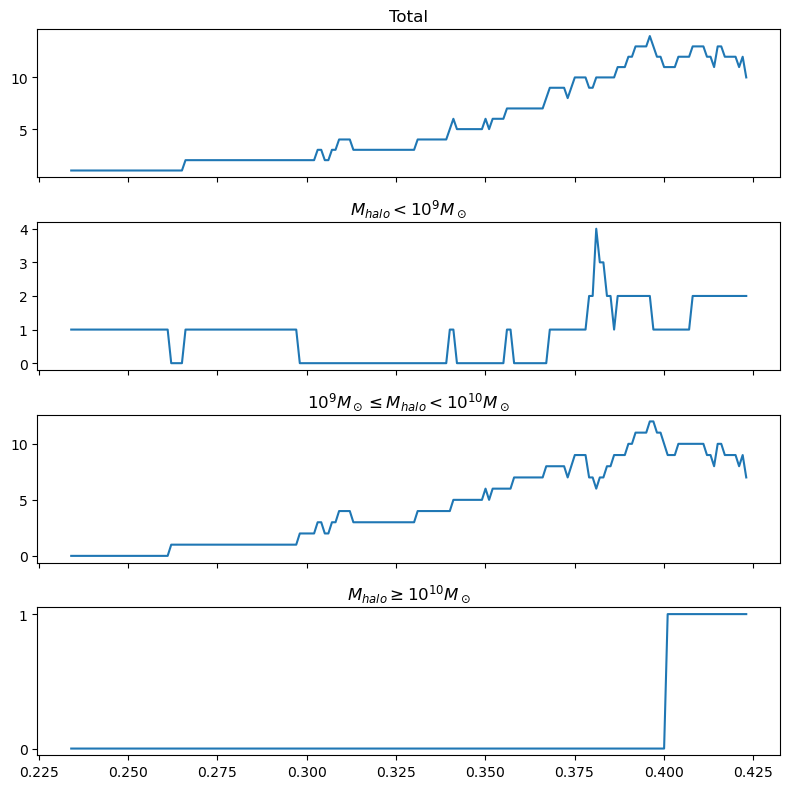

In [44]:
fig, axs = plt.subplots(ncols=1, nrows=4, sharex = True, figsize=(8,8))
axs[0].plot(time, n_halowstars_total)
axs[0].set_title('Total')

axs[1].plot(time, n_halowstars_range1)
axs[1].set_title(r'$M_{halo} < 10^{9} M_\odot$')

axs[2].plot(time, n_halowstars_range2)
axs[2].set_title(r'$10^{9} M_\odot \leq M_{halo} < 10^{10} M_\odot$')

axs[3].plot(time, n_halowstars_range3)
axs[3].set_title(r'$M_{halo} \geq 10^{10} M_\odot$')
axs[3].set_yticks([0,1])

fig.tight_layout()

In [60]:
def halom_sm_sfr(idx):
    halom = []
    sm = []
    sfr =[]
    redshift = ray_tree['0'][idx]['redshift']
    for branch in output_check[idx].keys():
        if output_check[idx][branch]['total_mass'] > 0:
            sm.append(output_check[idx][branch]['total_mass'])
            halom.append(ray_rawtree[branch][int(idx)]['Halo_Mass'])
            sfr.append(output_check[idx][branch]['sfr'])
    return halom, sm, sfr, redshift

In [62]:
halom1, sm1, sfr1, redshift1 = halom_sm_sfr('108')
halom, sm, sfr, redshift = halom_sm_sfr('211')
halom0, sm0, sfr0, redshift0 = [], [], [], 17.49

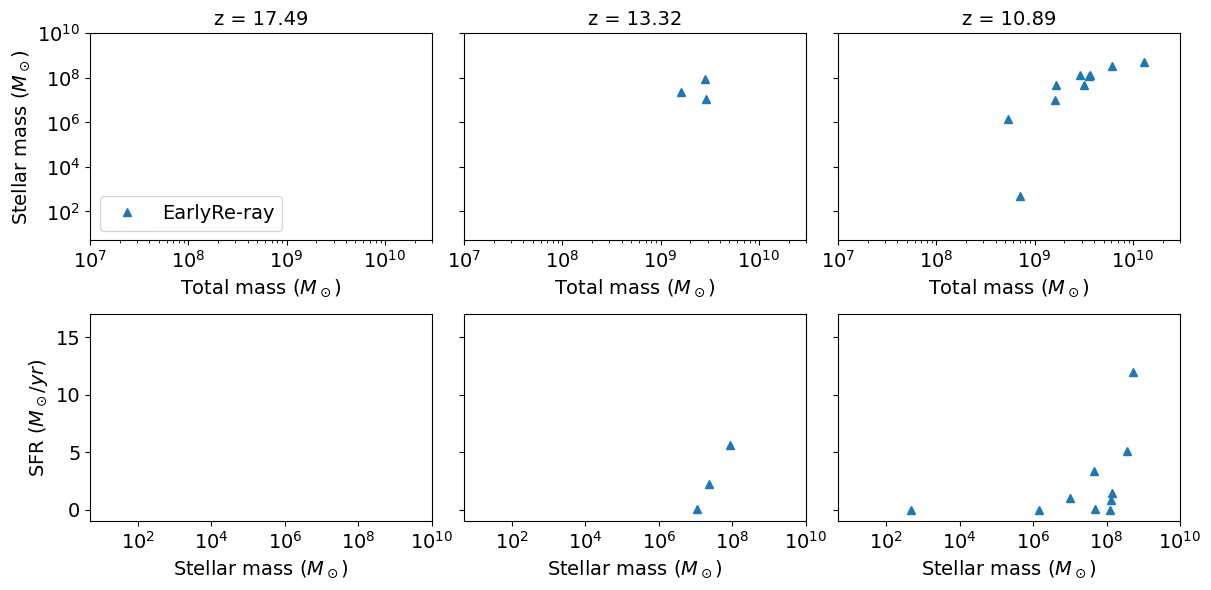

In [63]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharey = 'row', figsize=(12,6))

axs[0,0].plot(halom0, sm0,'^',label='EarlyRe-ray')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,0].set_ylabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[0,0].set_ylim([0.5e1,1e10])
axs[0,0].set_xlim(1e7,3e10)
axs[0,0].set_title('z = %.2f' % redshift0, fontsize=14)
#plt.xticks([1e6,1e7,1e8,1e9,1e10])
axs[0,0].legend(loc='lower left', fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)

axs[1,0].plot(sm0, sfr0,'^',label='EarlyRe-ray')
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,0].set_ylabel(r'SFR ($M_\odot/yr$)', fontsize=14)
axs[1,0].set_xlim([0.5e1,1e10])
axs[1,0].set_ylim([-1,17])
axs[1,0].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,1].plot(halom1, sm1,'^',label='EarlyRe-ray')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,1].set_ylim([0.5e1,1e10])
axs[0,1].set_xlim(1e7,3e10)
axs[0,1].set_title('z = %.2f' % redshift1, fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)

axs[1,1].plot(sm1, sfr1,'^',label='EarlyRe-ray')
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,1].set_xlim([0.5e1,1e10])
axs[1,1].set_ylim([-1,17])
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,2].plot(halom, sm,'^',label='EarlyRe-ray')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,2].set_ylim([0.5e1,1e10])
axs[0,2].set_xlim(1e7,3e10)
axs[0,2].set_title('z = %.2f' % redshift, fontsize=14)
axs[0,2].tick_params(axis='both', which='major', labelsize=14)

axs[1,2].plot(sm, sfr,'^',label='EarlyRe-ray')
axs[1,2].set_xscale('log')
axs[1,2].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,2].set_xlim([0.5e1,1e10])
axs[1,2].set_ylim([-1,17])
axs[1,2].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('/work/hdd/bbvl/tnguyen2/figures/self-shielding/SFR_stellarmass_totalmass_EarlyRe.png', dpi=300)

In [51]:
output_check['100']

{'1': {'ID': array([65333966, 65333967, 65333969, ..., 65440877, 65440878, 65440879]),
  'total_mass': 69602991.58186208,
  'sfr': 4.499585736544708},
 '7': {'ID': array([], dtype=int64), 'total_mass': 0.0, 'sfr': 0.0},
 '0_35': {'ID': array([65363536, 65363537, 65363538, 65363539, 65363540, 65363541,
         65363542, 65363543, 65363546, 65363549, 65363554, 65363555,
         65363558, 65363561, 65363565, 65363572, 65363576, 65363577,
         65363580, 65363587, 65363588, 65363590, 65363593, 65363596,
         65363599, 65363606, 65363607, 65363613, 65363616, 65363619,
         65363621, 65363624, 65363627, 65363636, 65363644, 65363646,
         65363648, 65363650, 65363651, 65363652, 65363653, 65363654,
         65363655, 65363656, 65363657, 65363658, 65363659, 65363660,
         65363661, 65363662, 65363663, 65363664, 65363665, 65363673,
         65363674, 65363683, 65363690, 65363698, 65363706, 65363714,
         65363722, 65363737, 65363738, 65363746, 65363753, 65363760,
       

In [10]:
output['101'].keys()

dict_keys(['1', '7', '0'])

In [10]:
ray_tree['1_22']['75']

{'tree_loc': '1_22',
 'coor': array([0.47356483, 0.50200012, 0.49968263]),
 'Rvir': 0.0017621845302556892,
 'redshift': 14.393940210744,
 'time': 0.2870843688082701,
 'gas_mass': 302999751.91776574,
 'gas_mass_frac': 0.1788584872392928,
 'h2_mass': 30722800.068975758,
 'h2_fraction': 0.1013954627834611,
 'dm_mass': 1370376768.8724527,
 'pop2_mass': 20698815.49721027,
 'pop3_mass': 0.0,
 'star_mass': 20698815.49721027,
 'metal_mass': 84355.03970861924,
 'metallicity': 0.0002783996989261999,
 'sfr': 0.0,
 'total_mass': 1694075336.2874289}

#### Testing each for loop step

In [61]:
idx = '196'
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
ds = yt.load(ray_pfs[int(idx)])

if idx == '21':
    ray_ID_all_prev = np.array([])

yt : [INFO     ] 2025-01-02 05:34:59,572 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 05:34:59,574 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 05:34:59,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 05:34:59,578 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 05:34:59,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 05:34:59,582 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 05:34:59,583 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 05:34:59,585 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 05:34:59,587 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 05:34:59,588 Parameters: hubble_constant           = 0.679


In [62]:
ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
print(ray_ID_unassign)
ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]

[65769579 65769581 65769590 65769591 65769592 65769593 65769594 65769595
 65769596 65769597 65769598 65769599 65769603 65769604 65769607 65769608
 65769609 65769611 65769614 65769615 65769618 65769619 65769622 65769624
 65769625 65769626 65769627 65769628 65769629 65769631 65769632 65769635
 65769637 65769638 65769639 65769640 65769641 65769643 65769645 65769646
 65769647 65769649 65769650 65769651 65769652 65769653 65769655 65769656
 65769659 65769660 65769661 65769662 65769663 65769666 65769667 65769669
 65769671 65769672 65769673 65769674 65769675 65769676 65769678 65769680
 65769682 65769683 65769684]


In [63]:
halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
print(halo_wstars_branch)

['0' '0_14' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_3' '8_2' '9' '9_1' '9_1_1_0' '9_1_0'
 '20' '69' '69_1']


In [12]:
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    if star_pos.shape == (3,):
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    else:
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    if star_pos.shape == (3,):
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    else:
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [13]:
def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [64]:
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
    
ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
halo_boolean_indp = halo_boolean[overlap_boolean == 1]

for j in range(halo_boolean_indp.shape[1]):
    starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    
if len(ray_ID_overlap) > 0:
    print('OVERLAP DETECTED')
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(ray_ID_overlap)):
        overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch, 'with energies', E_list)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])

OVERLAP DETECTED
Star ID 65769579 belong to Branch 9_1_0 with energies [2.27404812e+09 2.31908535e+09 2.04412294e+09 7.04623371e+08]
Star ID 65769581 belong to Branch 9_1_0 with energies [2.27488678e+09 2.31944627e+09 2.04462480e+09 7.14668490e+08]
Star ID 65769590 belong to Branch 1_8 with energies [ 8.63616905e+08 -1.52323347e+09]
Star ID 65769591 belong to Branch 1_8 with energies [ 8.61315863e+08 -1.51637336e+09]
Star ID 65769592 belong to Branch 1_8 with energies [ 8.61467133e+08 -1.51652629e+09]
Star ID 65769593 belong to Branch 1_8 with energies [ 8.61599742e+08 -1.51664657e+09]
Star ID 65769594 belong to Branch 1_8 with energies [ 8.61760352e+08 -1.51678897e+09]
Star ID 65769595 belong to Branch 1_8 with energies [ 8.55008091e+08 -1.50751866e+09]
Star ID 65769596 belong to Branch 1_8 with energies [ 8.61904304e+08 -1.51690079e+09]
Star ID 65769597 belong to Branch 1_8 with energies [ 8.55124601e+08 -1.50772976e+09]
Star ID 65769598 belong to Branch 1_8 with energies [ 8.6204122

In [ ]:
""" Old version before 01/01/2024
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
if len(overlap_boolean) > 0 and (overlap_boolean > 1).any() == True:
    print('OVERLAP DETECTED')
    for n in range(len(halo_wstars_branch)):
        starmap_ID.append(np.empty(0))
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(halo_boolean)):
        overlap_branch = halo_wstars_branch[halo_boolean[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
else: #if none of the stars are in overlapped halos
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
"""

In [65]:
i = 24
if len(starmap_ID[i]) > 0: 
    for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
        if int(j) >= int(idx):
            if halo_wstars_branch[i] not in output[j].keys():
                output[j][halo_wstars_branch[i]] = starmap_ID[i]
            else:
                output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
    if halo_wstars_branch[i].count('_') > 1:
        print('SUB-SUB-BRANCHES DETECTED AT SNAPSHOT', idx)
    nlevels = halo_wstars_branch[i].count('_')
    #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
    loop_branch = halo_wstars_branch[i]
    for level in range(nlevels):
        deepest_lvl = loop_branch.split('_')[-1]
        mainbranch = loop_branch.split('_' + deepest_lvl)[0]
        merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
        last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
        for j in range(merge_timestep, last_timestep + 1):
            if mainbranch not in output[str(j)].keys():
                output[str(j)][mainbranch] = starmap_ID[i]
            else:
                output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
        loop_branch = mainbranch

SUB-SUB-BRANCHES DETECTED AT SNAPSHOT 196


In [71]:
output['210']['9_1_0']

array([65769579, 65769581])

In [31]:
ray_tree['9'].keys()

dict_keys(['158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211'])

In [26]:
ray_tree[halo_wstars_branch[i]].keys()

dict_keys(['47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195',

To do:
+ In a case where one particle belongs to multiple halos, write code to assign that star to a specific halo -> done
+ If a star particle belongs to a sub-branch (for example, '0_20'), add it to the main branch when the halos merge (in the example, add it to branch '0') (done, however, the code doesn't account for sub-sub halos yet (or deeper sub-branches) -> done
+ In the final step, double check whether all stars are located in each halos of all snapshots. If they are not, remove them. -> done


In [342]:
len(output['57']['1'])

269

### Star Assignment Technique using Energy Definition

In [2]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

In [3]:
def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

In [4]:
def find_total_E(star_r, star_relvel_mag, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
idx = 170
branch = '0'

In [7]:
ds = yt.load(ray_pfs[idx])

yt : [INFO     ] 2024-12-13 18:28:03,482 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2024-12-13 18:28:03,484 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-13 18:28:03,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-13 18:28:03,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-13 18:28:03,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-13 18:28:03,488 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-13 18:28:03,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-13 18:28:03,491 Parameters: hubble_constant           = 0.679


In [8]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [32]:
ray_halo_center = ray_rawtree[branch][idx]['Halo_Center']
ray_halo_rvir = ray_rawtree[branch][idx]['Halo_Radius']
ray_halo_vel = ray_rawtree[branch][idx]['Vel_Com']

In [33]:
halo_boolean = np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir
halo_star_pos = ray_pos_all[halo_boolean]
halo_star_r = np.linalg.norm(halo_star_pos - ray_halo_center, axis=1)
halo_star_r = (halo_star_r*ds.units.code_length).to('m').v
halo_star_vel = ray_vel_all[halo_boolean]
halo_star_relvel_mag = np.linalg.norm(halo_star_vel - ray_halo_vel, axis=1)
halo_star_relvel_mag = (halo_star_relvel_mag*ds.units.km/ds.units.s).to('m/s').v
halo_star_age = ray_age_all[halo_boolean]
halo_star_ID = ray_ID_all[halo_boolean]

In [34]:
E_list = []
for j in range(len(halo_star_r)):
    E_list.append(find_total_E(halo_star_r[j], halo_star_relvel_mag[j], ds, ray_rawtree, branch, idx))
E_list = np.array(E_list)

Text(0.5, 0, 'Distance to Halo Center / Rvir')

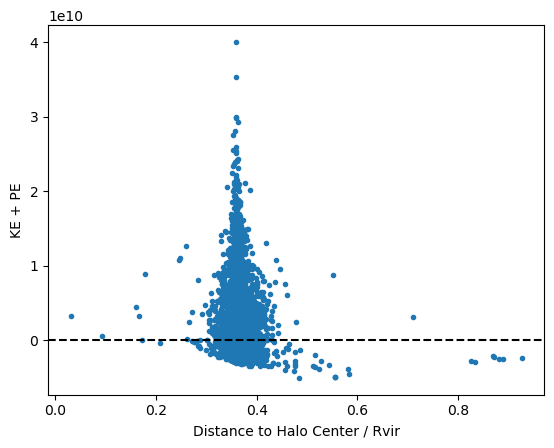

In [35]:
#sns.kdeplot(x = halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), y = E_list, fill=True)
plt.plot(halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), E_list, '.')
plt.axhline(0, linestyle='--', color='black')
plt.ylabel('KE + PE')
plt.xlabel('Distance to Halo Center / Rvir')

Only 30% of the stars are bound, which is unlikely. The error may come from the fact that the center of the stellar population is significantly off from the halo center, this introduces errors in the energy calculation. 

Suggestion from Kirk: subtract 

Use peak to determine the group of 

### Star Assignment Technique from AGORA Paper V and VII

Because SHINBAD output doesn't store the maximum circular velocity, we need to estimate it from the circular velocity at the virial radius

In [2]:
def weighted_std(values, weights_list):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights_list)
    N = len(values)
    # Fast and numerically precise:
    variance = np.sum(weights_list*(values-average)**2)/((N-1)*np.sum(weights_list)/N)
    return np.sqrt(variance)

In [3]:
def star_assignment(tree, branch, idx, pfs, sigma_cut = 2, distance_cut = 2):
    ds = yt.load(pfs[int(idx)])
    #
    branch = '0_4'
    halo_center = tree[branch][int(idx)]['Halo_Center']
    halo_rvir = tree[branch][int(idx)]['Halo_Radius']
    halo_mass = tree[branch][int(idx)]['Halo_Mass']
    halo_vel = tree[branch][int(idx)]['Vel_Com']
    halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v
    #
    halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
    halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
    vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir
    #

In [17]:
idx = '194'
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
ds = yt.load(ray_pfs[int(idx)])

yt : [INFO     ] 2024-12-11 16:59:32,587 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2024-12-11 16:59:32,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-11 16:59:32,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-11 16:59:32,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-11 16:59:32,597 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-11 16:59:32,600 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2024-12-11 16:59:32,602 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-11 16:59:32,604 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: hubble_constant           = 0.679


In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [18]:
branch = '0'
halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
halo_rvir = ray_rawtree[branch][int(idx)]['Halo_Radius']
halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
halo_vel = ray_rawtree[branch][int(idx)]['Vel_Com']
halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v

halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir

In [19]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [20]:
#Identify all the stars within the halo region
inreg_bool = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_rvir
inreg_pos = ray_pos_all[inreg_bool]
inreg_r = np.linalg.norm(inreg_pos - halo_center, axis=1)
#
inreg_vel = ray_vel_all[inreg_bool]
inreg_relvel = inreg_vel - halo_vel
inreg_relvelmag = np.linalg.norm(inreg_relvel, axis=1)
#
inreg_ID = ray_ID_all[inreg_bool]
inreg_mass = ray_mass_all[inreg_bool]

In [21]:
sigma_cut = 2
distance_cut = 2

In [22]:
reduced_bool = np.logical_and(inreg_r < 0.8*halo_rvir, inreg_relvelmag < 4*vcir)
reduced_mass = inreg_mass[reduced_bool]
reduced_pos = inreg_pos[reduced_bool]
reduced_com = np.average(reduced_pos, weights=reduced_mass, axis=0)
#
reduced_vel = inreg_vel[reduced_bool]
reduced_relvel = reduced_vel - np.average(reduced_vel, weights=reduced_mass, axis=0)
reduced_relvelmag = np.linalg.norm(reduced_relvel, axis=1)
sigma_vel = weighted_std(reduced_relvelmag, weights_list=reduced_mass)
#
reduced_ID = inreg_ID[reduced_bool]

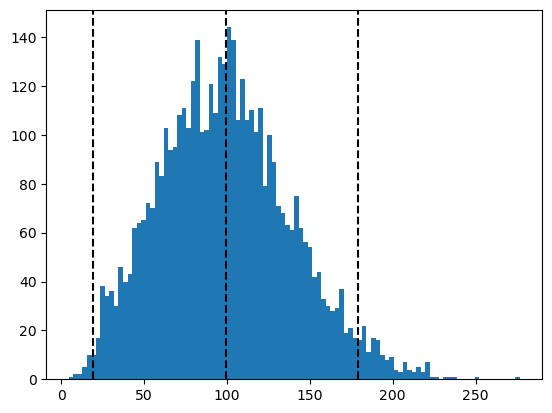

In [11]:
plt.hist(reduced_relvelmag, bins=100)
plt.axvline(np.average(reduced_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) - sigma_cut*sigma_vel, color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

In [23]:
def cal_R90(pos, center, mass):
    r = np.linalg.norm(pos - center, axis=1)
    r_sort = r[np.argsort(r)]
    mass_sort = mass[np.argsort(r)]
    mass_cumsum = np.cumsum(mass_sort)
    mass_cumsumpercent = mass_cumsum/mass_cumsum[-1]
    R90 = r_sort[np.where(mass_cumsumpercent > 0.9)[0][0]]
    return R90

In [24]:
r90_halocenter = cal_R90(reduced_pos, halo_center, reduced_mass)
r90_starcenter = cal_R90(reduced_pos, reduced_com, reduced_mass)

In [25]:
reduced2_bool = (np.linalg.norm(reduced_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                (np.linalg.norm(reduced_pos - reduced_com, axis=1) < distance_cut*r90_starcenter) & \
                (reduced_relvelmag <= np.average(reduced_relvelmag) + sigma_cut*sigma_vel)
reduced2_pos = reduced_pos[reduced2_bool]
reduced2_mass = reduced_mass[reduced2_bool]
reduced2_ID = reduced_ID[reduced2_bool]
reduced2_vel = reduced_vel[reduced2_bool]
reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)

In [26]:
counter = 0
while np.sum(reduced2_bool)/len(reduced2_bool) <= 0.99:
    if len(reduced2_pos) == 0:
        reduced2_com = np.nan
        break
    reduced2_relvel = reduced2_vel - np.average(reduced2_vel, weights=reduced2_mass, axis=0)
    reduced2_relvelmag = np.linalg.norm(reduced2_relvel, axis=1)
    #
    sigma_vel = weighted_std(reduced2_relvelmag, weights_list=reduced2_mass)
    r90_halocenter = cal_R90(reduced2_pos, halo_center, reduced2_mass)
    r90_starcenter = cal_R90(reduced2_pos, reduced2_com, reduced2_mass)
    #
    reduced2_bool = (np.linalg.norm(reduced2_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                    (np.linalg.norm(reduced2_pos - reduced2_com, axis=1) < distance_cut*r90_starcenter) & \
                    (reduced2_relvelmag <= np.average(reduced2_relvelmag) + sigma_cut*sigma_vel)
    reduced2_pos = reduced2_pos[reduced2_bool]
    reduced2_mass = reduced2_mass[reduced2_bool]
    reduced2_ID = reduced2_ID[reduced2_bool]
    reduced2_vel = reduced2_vel[reduced2_bool]
    reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)
    counter += 1
    print(counter)

1
2
3


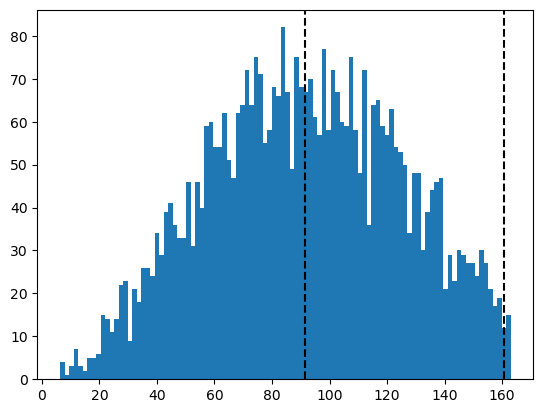

In [19]:
plt.hist(reduced2_relvelmag, bins=100)
plt.axvline(np.average(reduced2_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced2_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

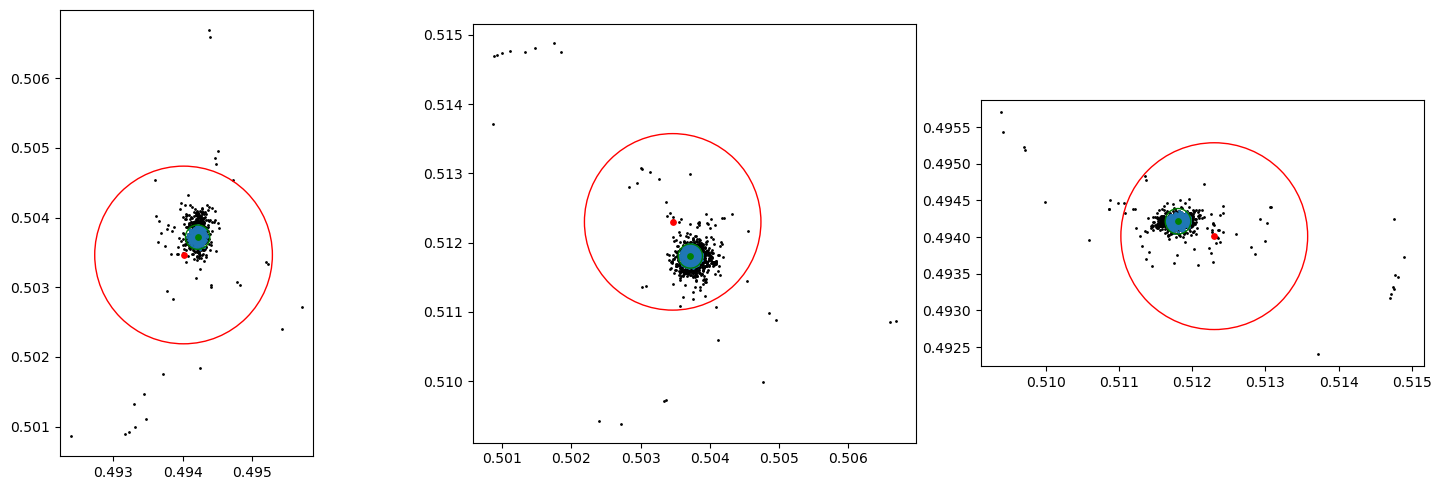

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axs[0].scatter(inreg_pos[:,0], inreg_pos[:,1], s=1, color='black')

axs[0].scatter(reduced2_pos[:,0], reduced2_pos[:,1], s=1)

axs[0].scatter(halo_center[0], halo_center[1], color='red', s=15)
circle1 = plt.Circle((halo_center[0], halo_center[1]), distance_cut*r90_halocenter, color='red', fill=False)
axs[0].add_patch(circle1)

axs[0].scatter(reduced2_com[0], reduced2_com[1], color='green', s=15)
circle2 = plt.Circle((reduced2_com[0], reduced2_com[1]), distance_cut*r90_starcenter, color='green', fill=False)
axs[0].add_patch(circle2)

axs[0].set_aspect('equal')

#---------------------------------------------------------
axs[1].scatter(inreg_pos[:,1], inreg_pos[:,2], s=1, color='black')

axs[1].scatter(reduced2_pos[:,1], reduced2_pos[:,2], s=1)

axs[1].scatter(halo_center[1], halo_center[2], color='red', s=15)
circle1 = plt.Circle((halo_center[1], halo_center[2]), distance_cut*r90_halocenter, color='red', fill=False)
axs[1].add_patch(circle1)

axs[1].scatter(reduced2_com[1], reduced2_com[2], color='green', s=15)
circle2 = plt.Circle((reduced2_com[1], reduced2_com[2]), distance_cut*r90_starcenter, color='green', fill=False)
axs[1].add_patch(circle2)

axs[1].set_aspect('equal')
#---------------------------------------------------------
axs[2].scatter(inreg_pos[:,2], inreg_pos[:,0], s=1, color='black')

axs[2].scatter(reduced2_pos[:,2], reduced2_pos[:,0], s=1)

axs[2].scatter(halo_center[2], halo_center[0], color='red', s=15)
circle1 = plt.Circle((halo_center[2], halo_center[0]), distance_cut*r90_halocenter, color='red', fill=False)
axs[2].add_patch(circle1)

axs[2].scatter(reduced2_com[2], reduced2_com[0], color='green', s=15)
circle2 = plt.Circle((reduced2_com[2], reduced2_com[0]), distance_cut*r90_starcenter, color='green', fill=False)
axs[2].add_patch(circle2)

axs[2].set_aspect('equal')

fig.tight_layout()